In [5]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

<IPython.core.display.Javascript object>

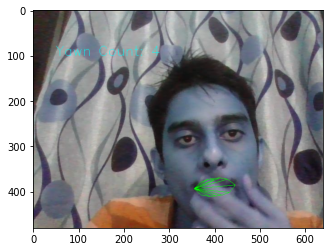

In [9]:
# JavaScript to properly create our live video stream using our webcam as input


def video_stream():
    js = \
        Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

    display(js)


def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data


import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
path = \
    '/content/drive/MyDrive/shape predictor /shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(path)
detector = dlib.get_frontal_face_detector()


def get_landmarks(im):
    rects = detector(im, 1)  # image and no.of rectangles to be drawn
    if len(rects) > 1:
        print('Toomanyfaces')  
        return np.matrix([0])
    if len(rects) == 0:
        print( 'Toofewfaces')
        return np.matrix([0])
    return np.matrix([[p.x, p.y] for p in predictor(im,
                     rects[0]).parts()])


def place_landmarks(im, landmarks):
    im = im.copy()
    for (idx, point) in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(
            im,
            str(idx),
            pos,
            fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
            fontScale=0.3,
            color=(0, 255, 255),
            )
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im


def upper_lip(landmarks):
    top_lip = []
    for i in range(50, 53):
        top_lip.append(landmarks[i])
    for j in range(61, 64):
        top_lip.append(landmarks[j])
    top_lip_point = np.squeeze(np.asarray(top_lip))
    top_mean = np.mean(top_lip_point, axis=0)
    return int(top_mean[1])


def low_lip(landmarks):
    lower_lip = []
    for i in range(65, 68):
        lower_lip.append(landmarks[i])
    for j in range(56, 59):
        lower_lip.append(landmarks[j])
    lower_lip_point = np.squeeze(np.asarray(lower_lip))
    lower_mean = np.mean(lower_lip_point, axis=0)

    return int(lower_mean[1])


def decision(image):
    landmarks = get_landmarks(image)
    if landmarks.all() == [0]:
        return -10  # Dummy value to prevent error
    top_lip = upper_lip(landmarks)
    lower_lip = low_lip(landmarks)
    distance = abs(top_lip - lower_lip)
    return distance


# start streaming video from webcam

video_stream()

# label for video

label_html = 'Capturing...'

# initialze bounding box to empty

bbox = ''

yawns = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image

    frame = js_to_image(js_reply['img'])

    landmarks = get_landmarks(frame)
    if landmarks.all() != [0]:
        l1 = []
        for k in range(48, 60):
            l1.append(landmarks[k])
            l2 = np.asarray(l1)
            lips = cv2.convexHull(l2)
            cv2.drawContours(frame, [lips], -1, (0, 255, 0), 1)

    distance = decision(frame)
    if distance > 21:  # Use distance according to your convenience
        yawns = yawns + 1

    cv2.putText(
        frame,
        'Yawn Count: ' + str(yawns),
        (50, 100),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1.0,
        color=(0, 255, 255),
        )
    plt.imshow(frame)
    if cv2.waitKey(1) == 13:
        break
    else:
        continue
 